In [3]:
#import external libraries
import pandas as pd
import datetime
import pytz
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
import scipy
#plotting
%matplotlib notebook
import seaborn as sns; sns.set(style='whitegrid', rc={'figure.figsize':(8.27, 11.7)}) #set seaborn figure size to A4 paper
#import self-written libraries
from settings import Glacier, Station, base_path
import CleanWxData
import plot_funcs

In [4]:
#Decide what you're looking at
category='precip' #temp or precip

#save plots
save_plots=False

In [3]:
#Read in data
data_dir=base_path +"Data/"+Glacier+ r"/AllYears/Wx/LVL2/emily/"
fl=Glacier.lower()+ Station + "_daily_"+"LVL2.csv"
pth=os.path.join(data_dir, fl)
dat=pd.read_csv(pth)
print("read data from "+ pth)

#Set time index
dat.Date=pd.to_datetime(dat.Date, format='%Y/%m/%d')

read data from Q:/Project Data/GlacierData/Benchmark_Program/Data/Wolverine/AllYears/Wx/LVL2/emily/wolverine990_daily_LVL2.csv


In [4]:
if category=='precip':
    change_date=dat.TPG_Precip.first_valid_index()
    tpg_dat=dat.TPG_Precip[change_date:]
    stage_dat=dat.Stage_Precip[:change_date]

In [5]:
if category=='temp':
    select_dat=dat[['Temp_USGS', 'Temp_WMO', 'Temp_min','Temp_max', 'Date']]
    var='Temp_USGS'
    dat[var].name='Daily Average Temperature (USGS)'

In [6]:
if category=='precip':
    select_dat=dat[['Stage_Precip', 'TPG_Precip', 'Date']]
    var='TPG_Precip'
    dat[var].name='Daily Precip'

In [7]:
#Create melted dataframe
m_dat_temp=pd.melt(select_dat, id_vars=['Date'])

In [9]:
m_dat_temp.tail(2)

,Date,variable,value
14632,2017-09-08,TPG_Precip,2.0
14633,2017-09-09,TPG_Precip,0.0


In [10]:
#Create numeric formulation of date
dat=dat.set_index('Date')
dat['jDate'] = dat.index.to_julian_date()
dat['decimal_date']=CleanWxData.decimal_date_from_julian(dat.jDate)

In [11]:
#normality check
scipy.stats.shapiro(dat[var].dropna()) #output is test statistic, p-val; if < 0.05 then not normally distributed

(0.48554307222366333, 0.0)

In [12]:
import imp
imp.reload(plot_funcs)

<module 'plot_funcs' from 'C:\\Users\\ehbaker\\Documents\\Python\\Modules\\plot_funcs.py'>

p= 0.03


<IPython.core.display.Javascript object>


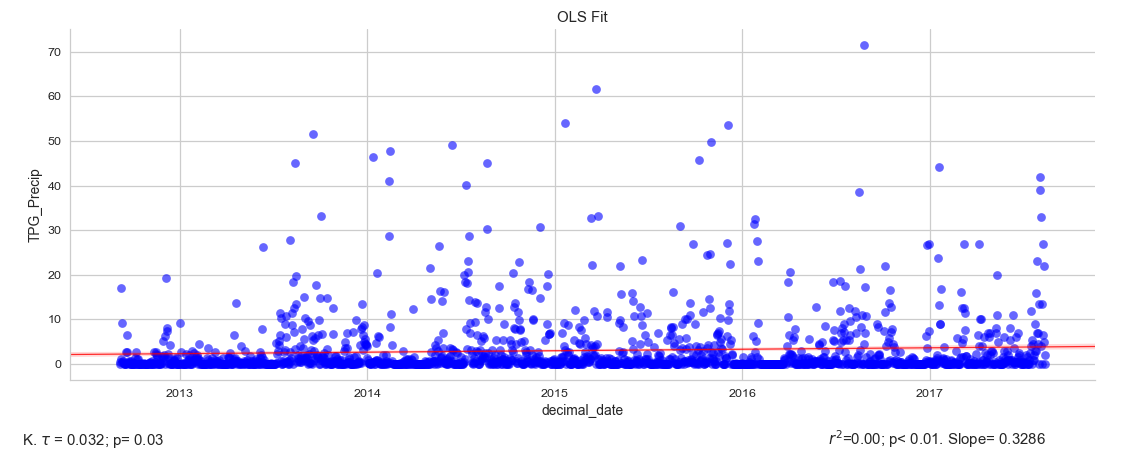

In [19]:
#Simple  OLS plot
sns.set(rc={'figure.figsize':(12, 6)}, style='whitegrid') #set seaborn figure size to A4 paper
fig=plot_funcs.OLS_plot('decimal_date', var, dat=dat.dropna(subset=[var]), title='OLS Fit', aspect=2.5)
if save_plots:
    plt.savefig('./figs/trends/' + Glacier + Station+ '_SimpleOLS_Daily_'+ var +'.jpg')

In [30]:
# #OLS regression
# res=sm.OLS(dat[var], dat.decimal_date, missing='drop').fit()
# pval=res.pvalues['decimal_date']
# r2=res.rsquared_adj
# slope=res.params['decimal_date']

# #Kendal-Tau (non-parametric)
# kendall_tau, kt_pval=scipy.stats.stats.kendalltau(dat[var], dat.decimal_date, nan_policy="omit")
# kt_pval=plot_funcs.pretty_p_val(kt_pval)

# print("r2=" +str(r2)[0:4]+ "; " +plot_funcs.pretty_p_val(pval) + ". Slope= " + str(slope.round(12)))
# print("K. Tau = " + str(kendall_tau)[0:5] + "; " + kt_pval)

In [13]:
#Test first and last 10 yrs of data to see if different
yrmin=dat.index.year.min()
yrmax=dat.index.year.max()
dat['year']=dat.index.year
# dat['stage']=pd.np.nan #stage is categorical variable indicating if early or late in timeseries
# dat.loc[(dat.year>=yrmin) & (dat.year<=yrmin+10), 'stage']='early'
# dat.loc[(dat.year>=yrmax-10) & (dat.year<=yrmax), 'stage']='recent'
# older_data=dat[var][dat.stage=='early']
# recent_data=dat[var][dat.stage=='recent']
# ttest=scipy.stats.ttest_ind(older_data, recent_data)
# ttest.pvalue

In [13]:
m_dat_temp.set_index('Date', inplace=True)

In [14]:
m_dat_temp['year']=m_dat_temp.index.year
m_dat_temp['month']=m_dat_temp.index.month

In [15]:
m_dat_temp.head(1)

,variable,value,year,month
Date,,,,
1997-08-29,Stage_Precip,NaN,1997,8


<IPython.core.display.Javascript object>


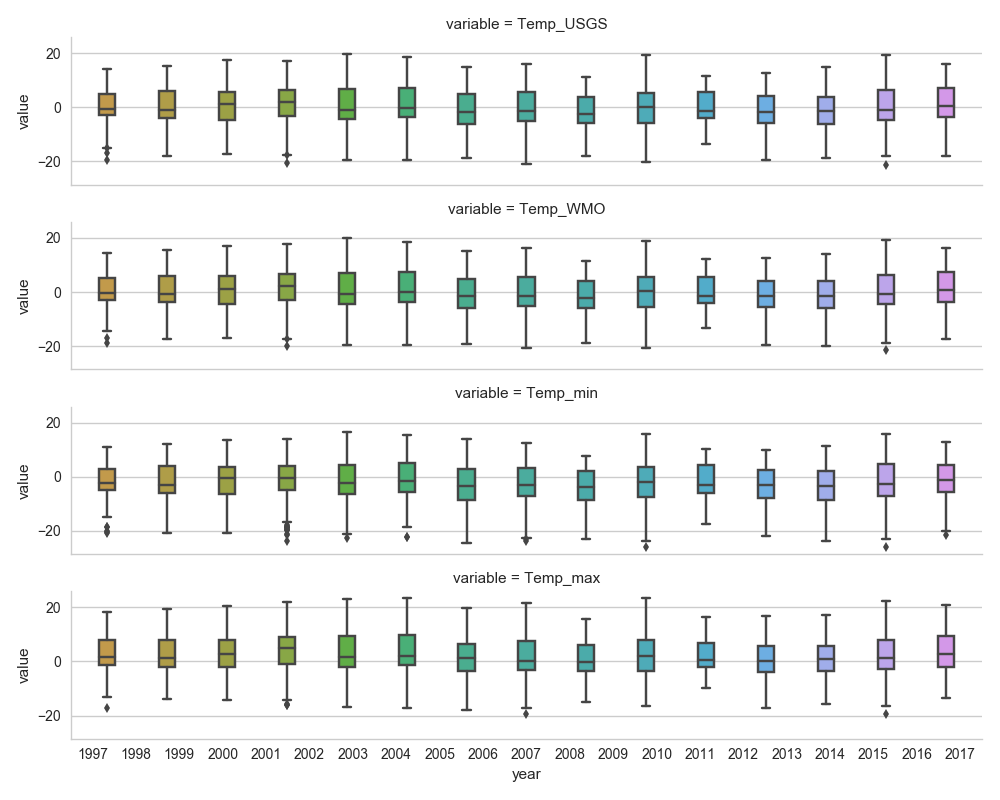

In [17]:
g=sns.factorplot(x='year', y='value', hue='year', row='variable', data=m_dat_temp, kind='box', aspect=5, size=2, width=8)

In [29]:
save_nm= os.curdir + r"/figs/temp_timeseries_boxplot_"+ Glacier + Station+ ".jpg"
g.savefig(save_nm)

<IPython.core.display.Javascript object>


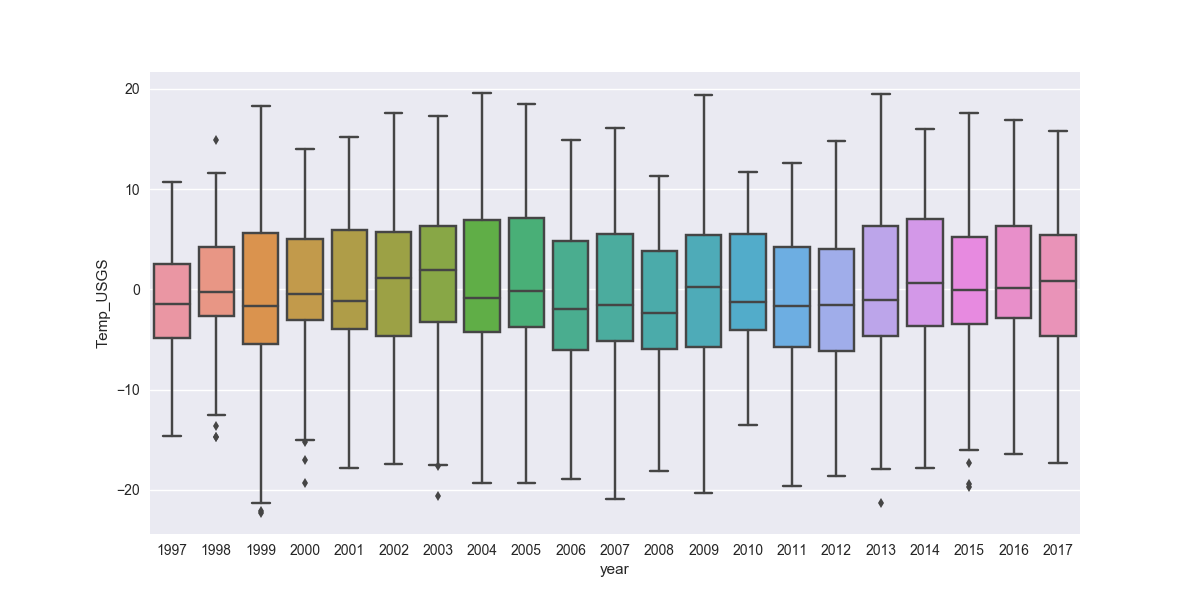

./figs/temp_boxplot_Wolverine990_Temp_USGS.jpg


In [33]:
plt.figure()
sns.set(rc={'figure.figsize':(12, 6)}) #set seaborn figure size to A4 paper
g=sns.boxplot(x="year", y=var, data=dat)
save_nm= "./figs/temp_boxplot_"+ Glacier + Station + "_" + var+ ".jpg"
plt.savefig(save_nm)
print(save_nm)

In [111]:
#Make plot of linear model w/o removal of seasonality

<IPython.core.display.Javascript object>


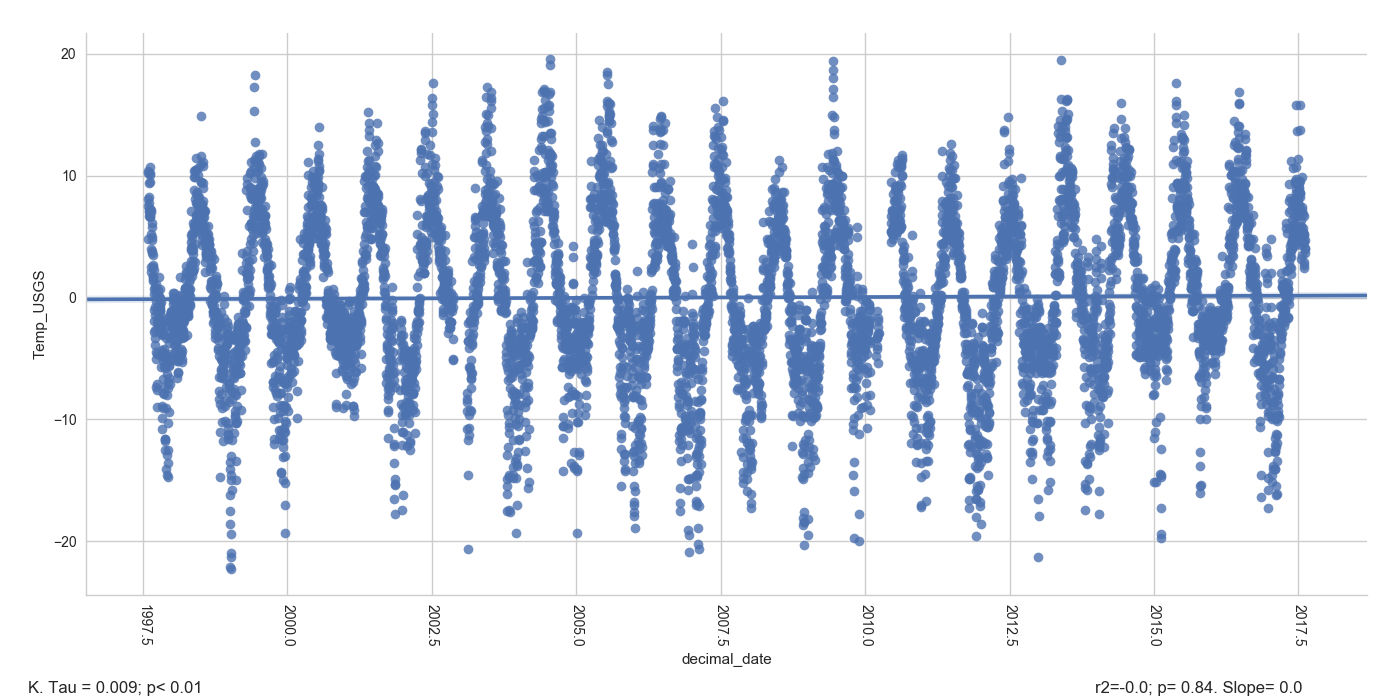

p= 0.84


In [42]:
ax=sns.lmplot(y='Temp_USGS', x='decimal_date', data=dat, size=7, aspect=2)
plt.xticks(rotation=-90)
summary_text="r2=" +str(r2)[0:4]+ "; " +plot_funcs.pretty_p_val(pval) + ". Slope= " + str(slope.round(4))
plt.tight_layout(pad=2)
plt.figtext(0.93, 0.01, summary_text, horizontalalignment='right')
plt.figtext(0.02, 0.01, "K. Tau = " + str(kendall_tau)[0:5] + "; " + kt_pval, horizontalalignment='left')
plt.savefig('./figs/'+"lmplot_daily_" + var + "_"+ Glacier + Station+ ".jpg")

In [36]:
#Fill gaps in data for seasonality plot
sns.set(rc={'figure.figsize':(10, 8)}) #set seaborn figure size to A4 paper
#First, fill data
idx=pd.date_range(dat.index[0], dat.index[-1]) #THIS WORKS FOR DAILY DATA; MUST BE CHANGED FOR ANYTHING ELSE
temp_filled=dat.Temp_USGS.reindex(idx, fill_value=pd.np.nan)

In [37]:
#Deal with adding dates to x-axis
temp_filled=temp_filled.interpolate()
jan1s=temp_filled.index[temp_filled.index.dayofyear==1]
jan1_labels=jan1s.year
idx_jan1s=[temp_filled.index.get_loc(x) for x in jan1s]

C:\Users\ehbaker\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\tsa\filters\filtertools.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.r_[[np.nan] * head, x, [np.nan] * tail]


<IPython.core.display.Javascript object>


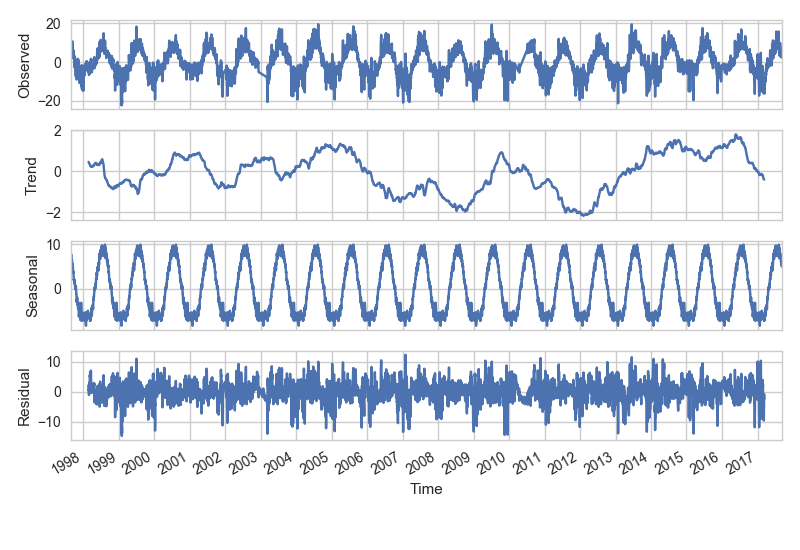

In [41]:
#Make decomposition plot
decomposition= sm.tsa.seasonal_decompose(temp_filled.values, model='additive', freq=365) #frequency is yearly, but must be integer
fig = decomposition.plot()
my_xticks=jan1_labels
plt.xticks(idx_jan1s, my_xticks)
plt.show()
fig.autofmt_xdate()
plt.savefig("./figs/seasonal_trend_decompositon_"+ var+ "_"+ Glacier + Station+ ".jpg")

<IPython.core.display.Javascript object>


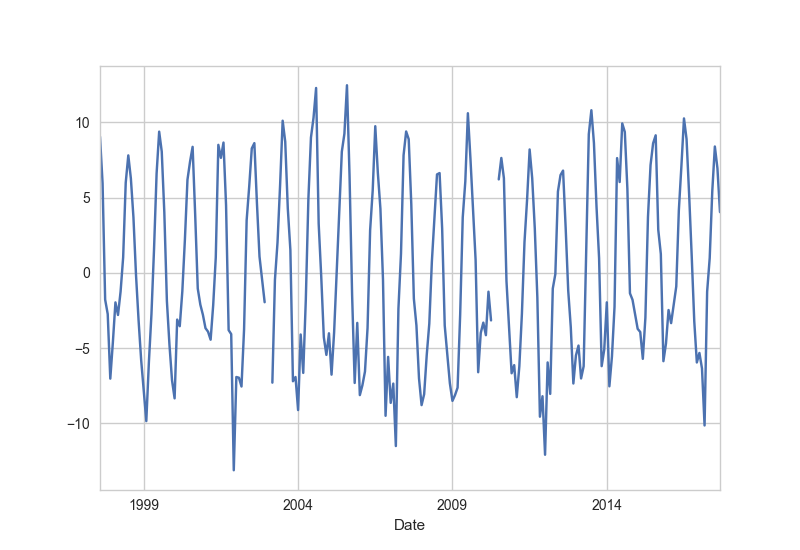

In [45]:
#Resample to monthly

y=dat.Temp_USGS.resample('MS').mean()
plt.figure()
y.plot()

In [ ]:
import pandas 